In [2]:
#pip install pyathena

In [5]:
#pip install pycountry

In [7]:
#pip install pycountry-convert

In [8]:
#Libraries
from pyathena import connect
import pandas as pd
import pycountry
import pycountry_convert as pc

In [9]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
table_name = 'daily_check'

In [10]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')

In [11]:
df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)

/tmp/ipykernel_296/2543410162.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)


In [12]:
df.head()

,payer,country,date,tx,amount
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55
1,ARGENPER,PERU,2023-04-03,26,4203.70
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00


In [56]:
df = df[df['amount'] != 0]

In [13]:
df['country'] = df['country'].str.strip().str.upper()

In [14]:
# Diccionario para mapear nombres no estándar a nombres reconocidos por pycountry
name_mappings = {
 'CZECH REPUBLIC': 'CZECHIA',
 "COTE D'IVOIRE (IVORY COAST)": "CÔTE D'IVOIRE",
 'UNITED STATES (ATM & DEPOSITS)': 'UNITED STATES',
 'CONGO, (CONGO Â– BRAZZAVILLE)': 'CONGO',
 'GAMBIA, THE': 'GAMBIA',
 'BOLIVIA': 'BOLIVIA, PLURINATIONAL STATE OF',
 'VIETNAM': 'VIET NAM',
 'TANZANIA': 'TANZANIA, UNITED REPUBLIC OF',
 'TURKEY': 'TÜRKIYE'
}

# Aplicar el mapeo al DataFrame
df['country'] = df['country'].replace(name_mappings)

In [15]:
'Bolivia, Plurinational State of'.upper()

'BOLIVIA, PLURINATIONAL STATE OF'

In [16]:
df['country'].unique()

array(['BELGIUM', 'PERU', 'GAMBIA', 'MEXICO', 'HONDURAS', 'NIGERIA',
       'ECUADOR', 'UNITED KINGDOM', 'BRAZIL', 'UNITED STATES',
       'PHILIPPINES', 'EL SALVADOR', 'NICARAGUA', 'GUATEMALA',
       'BOLIVIA, PLURINATIONAL STATE OF', 'HAITI', 'COSTA RICA',
       'DOMINICAN REPUBLIC', 'COLOMBIA', 'CHILE', 'SPAIN', 'SIERRA LEONE',
       'ARGENTINA', 'BANGLADESH', 'INDONESIA', 'GHANA', 'MALAYSIA',
       'GUINEA', 'CAMEROON', 'NEPAL', 'INDIA', 'THAILAND', 'FRANCE',
       'BENIN', 'BURKINA FASO', 'NETHERLANDS', 'PORTUGAL', 'URUGUAY',
       "CÔTE D'IVOIRE", 'SENEGAL', 'TOGO', 'RWANDA', 'CAMBODIA', 'KENYA',
       'LIBERIA', 'GERMANY', 'JAMAICA', 'MALI', 'AUSTRIA', 'ITALY',
       'MAURITANIA', 'CONGO', 'TANZANIA, UNITED REPUBLIC OF', 'ZAMBIA',
       'FINLAND', 'SWITZERLAND', 'PAKISTAN', 'SINGAPORE', 'NORWAY',
       'CHAD', 'GABON', 'ETHIOPIA', 'SRI LANKA', 'TÜRKIYE', 'ROMANIA',
       'FIJI', 'UGANDA', 'VIET NAM', 'QATAR', 'IRELAND', 'LITHUANIA',
       'ZIMBABWE', 'POLAND', 'LUXEM

In [17]:
df['country'].nunique()

77

In [24]:
country_to_iso2 = {}
for country in pycountry.countries:
    try:
        country_to_iso2[country.alpha_2] = pycountry.subdivisions.get(country_code=country.alpha_2).continent.name
    except:
        pass

In [25]:
df['alpha2'] = df['country'].apply(lambda x: pycountry.countries.get(name=x).alpha_2 if pycountry.countries.get(name=x) else None)

In [26]:
df.head()

,payer,country,date,tx,amount,alpha2
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,BE
1,ARGENPER,PERU,2023-04-03,26,4203.70,PE
2,NAFA,GAMBIA,2023-04-03,8,1086.50,GM
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50,MX
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00,HN


In [27]:
def get_continent(country_alpha_2):
    try:
        return pc.country_alpha2_to_continent_code(country_alpha_2)
    except:
        return None

In [30]:
df['continent'] = df['alpha2'].apply(get_continent)

In [31]:
df.head()

,payer,country,date,tx,amount,alpha2,continent
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,BE,EU
1,ARGENPER,PERU,2023-04-03,26,4203.70,PE,SA
2,NAFA,GAMBIA,2023-04-03,8,1086.50,GM,AF
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50,MX,NA
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00,HN,NA


In [32]:
df['continent'].unique()

array(['EU', 'SA', 'AF', 'NA', 'AS', 'OC'], dtype=object)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93018 entries, 0 to 101969
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   payer      93018 non-null  object        
 1   country    93018 non-null  object        
 2   date       93018 non-null  datetime64[ns]
 3   tx         93018 non-null  int64         
 4   amount     93018 non-null  float64       
 5   alpha2     93018 non-null  object        
 6   continent  93018 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 5.7+ MB


In [34]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

In [35]:
# Sales analysis by country
sales_by_country = df.groupby('country')[['tx', 'amount']].sum()

# Sales analysis by continent
sales_by_continent = df.groupby('continent')[['tx', 'amount']].sum()

In [64]:
# Calculate the average amount per transaction for each continent
sales_by_continent['avg_amount_per_tx'] = sales_by_continent['amount'] / sales_by_continent['tx']

In [65]:
sales_by_continent.head()

,tx,amount,avg_amount_per_tx
continent,,,
AF,121753,4.344552e+07,356.833262
AS,1126070,7.093728e+08,629.954446
EU,5150,2.786686e+06,541.104091
NA,50256902,2.282037e+10,454.074380
OC,3,1.500000e+01,5.000000


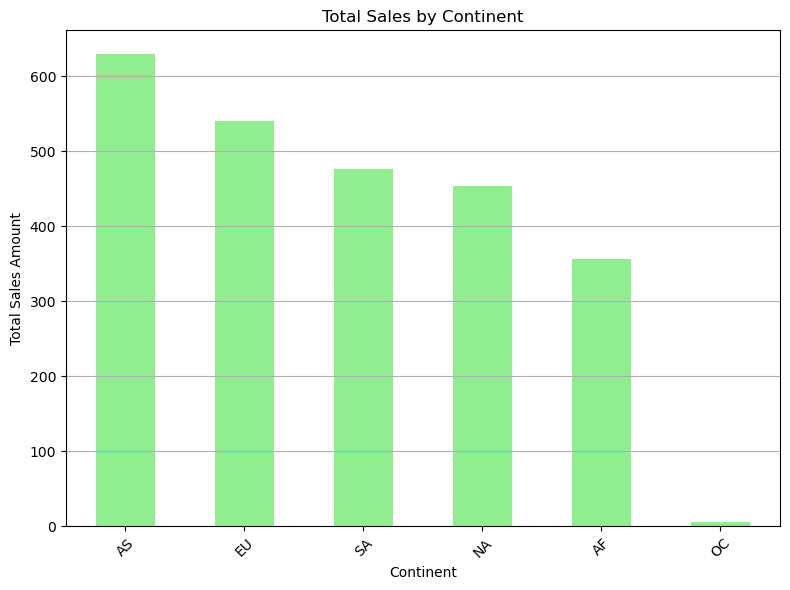

In [66]:
# Bar plot for sales by continent
plt.figure(figsize=(8, 6))
sales_by_continent['avg_amount_per_tx'].sort_values(ascending=False).plot(kind='bar', color='lightgreen')
plt.title('Total Sales by Continent')
plt.xlabel('Continent')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [67]:
# Filter data for the year 2023
df_2023 = df[df['date'].dt.year == 2023]

In [69]:
sales_by_continent_2023 = df_2023.groupby('continent')[['tx', 'amount']].sum()
sales_by_continent_2023['avg_amount_per_tx'] = sales_by_continent_2023['amount'] / sales_by_continent_2023['tx']

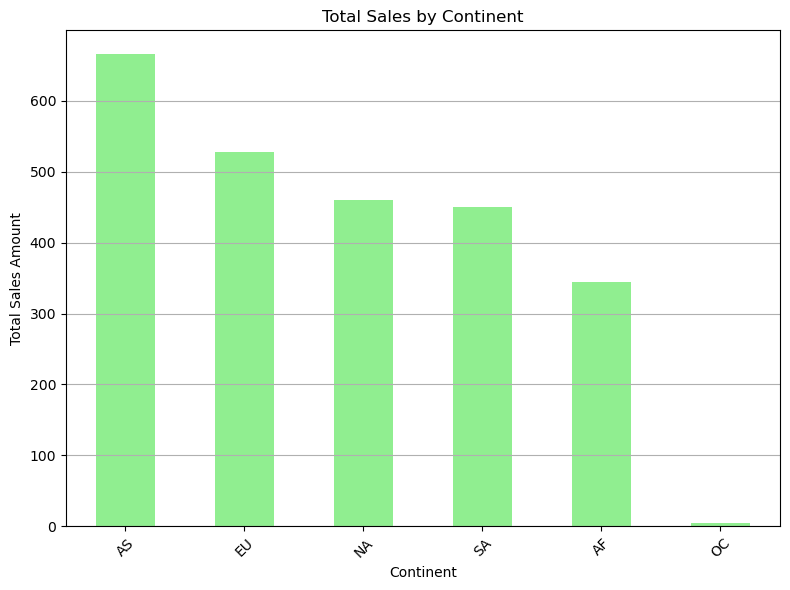

In [71]:
# Bar plot for sales by continent
plt.figure(figsize=(8, 6))
sales_by_continent_2023['avg_amount_per_tx'].sort_values(ascending=False).plot(kind='bar', color='lightgreen')
plt.title('Total Sales by Continent')
plt.xlabel('Continent')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [73]:
df[df['continent'] == 'AS']['country'].unique()

array(['PHILIPPINES', 'BANGLADESH', 'INDONESIA', 'MALAYSIA', 'NEPAL',
       'INDIA', 'THAILAND', 'CAMBODIA', 'SINGAPORE', 'TÜRKIYE',
       'SRI LANKA', 'QATAR', 'PAKISTAN'], dtype=object)

In [ ]:
#list(pycountry.countries)

In [ ]:
####### To detect countries to be formatted ############
# Countries included in my df
unique_countries = set(df['country'])

# Checking wich are not included in pycountry > To include in name_mappings dictionary
not_found_countries = [country for country in unique_countries if pycountry.countries.get(name=country) is None]
print(not_found_countries)